# Homework 8: Predicting Power Loads with LSTM Networks

## Due: Midnight on **Wednesday, October 29th** (with a 2-hour grace period)  
**Worth:** 85 points

In this assignment, you’ll build and analyze recurrent neural-network models to forecast hourly power demand, using the direct method, and comparing it with autoregressive methods.

**Direct (Non-Autoregressive) Time Series Prediction:**

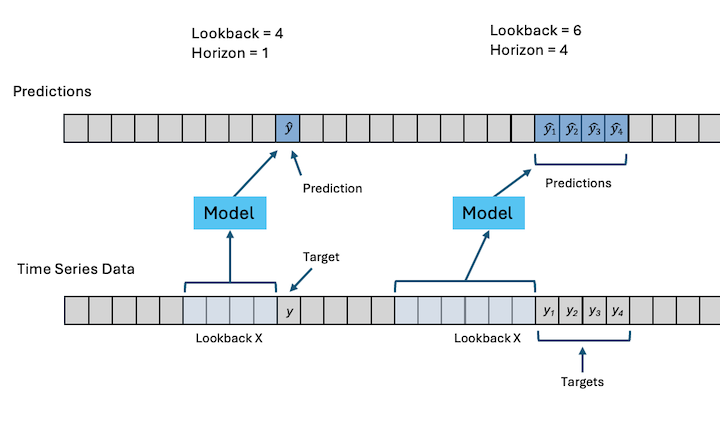


**What we'll do in this homework**

Starting from a working LSTM baseline, you’ll experiment with how the **direct** forcasting models performs, and investigate how **lookback**, **forecast horizon**, and **architecture** affect predictive accuracy and generalization.  
You’ll also explore an **autoregressive** variant, where the model rolls forward one hour at a time—an approach that often highlights how small errors can accumulate.

You’ll complete three problems:

* **Problem 1 — Exploring Lookback and Horizon:**  
  Adjust how far back the model looks and how far ahead it predicts, and examine how these design choices influence MAE/RMSE.

* **Problem 2 — Architectural Tweaks:**  
  Modify the LSTM architecture by deepening the network, stacking layers, or adding a bidirectional layer, and evaluate the effect on validation performance.

* **Problem 3 — Autoregressive Forecasting (ChatGPT Discussion):**  
  Work interactively with ChatGPT to design a one-step-at-a-time autoregressive version of your model, and discuss how it compares to your direct multi-output model.



For each problem, you'll report your best validation metrics, display the learning-curve plots, and briefly reflect on what you learned from the experiment.

There are 5 graded problems, worth 17 points each. 

## Setup and Data Loading


In [1]:
# ---------- Standard Library ----------
import os
import time
import math
import random
from pathlib import Path
from collections import Counter

# Environment (set BEFORE importing TensorFlow)
os.environ["PYTHONHASHSEED"] = "0"        # Disable hash randomization
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Deterministic TF ops where possible
os.environ["TF_CUDNN_DETERMINISM"] = "1"  # Deterministic CuDNN (if GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TF INFO/WARNING logs

# ---------- Third-Party (General) ----------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, ShuffleSplit
import kagglehub

# ---------- TensorFlow / Keras ----------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import GlobalMaxPooling1D, SpatialDropout1D, Bidirectional
# Layers (vision)
from tensorflow.keras.layers import (
    Input, Conv2D,Conv1D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    GlobalMaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout
)

# Preprocessing (vision)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---------- (Optional) NLP-related imports ----------
# If not doing NLP, you can safely remove this block.
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, LSTM, GRU, SpatialDropout1D, Bidirectional, Lambda
)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.datasets import imdb  # uncomment only if needed

# ---------- Reproducibility ----------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)  # covers TF, Python, and NumPy RNGs

# ---------- Convenience ----------
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

def format_hms(seconds: float) -> str:
    """Format seconds as H:MM:SS."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Example:
# start = time.time()
# ... your code ...
# print("Elapsed:", format_hms(time.time() - start))


/home/abcbbong/miniforge3/envs/vevn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Single global registry (scaled units)
results = {}   # title -> dict with selected-epoch metrics and (optional) diagnostics

def plot_learning_curves_scaled(
    history,
    title="Learning Curves — MAE & RMSE (scaled)",
    verbose=True,
    record_globals=False,   # set True if you also want global minima as diagnostics
):
    """
    Plot MAE/RMSE directly from Keras History (scaled units).
    Select the epoch by min `val_loss` and record all metrics at that epoch.
    """
    H = history.history if hasattr(history, "history") else history
    if not isinstance(H, dict):
        raise ValueError("history must be a Keras History or a dict")

    if "loss" not in H:
        raise ValueError("History must contain 'loss' (MSE).")

    has_val_loss = "val_loss" in H and len(H["val_loss"]) > 0

    loss     = np.asarray(H["loss"], dtype=float)
    val_loss = np.asarray(H["val_loss"], dtype=float) if has_val_loss else None

    mae      = np.asarray(H["mae"], dtype=float)      if "mae"      in H else None
    val_mae  = np.asarray(H["val_mae"], dtype=float)  if "val_mae"  in H else None
    rmse     = np.asarray(H["rmse"], dtype=float)     if "rmse"     in H else np.sqrt(loss)
    val_rmse = np.asarray(H["val_rmse"], dtype=float) if "val_rmse" in H else (np.sqrt(val_loss) if has_val_loss else None)

    epochs = np.arange(1, len(loss) + 1)

    # ----- Select epoch by min val_loss (or last if no validation) -----
    if has_val_loss:
        sel_idx = int(np.argmin(val_loss))
        sel_note = "min val_loss"
    else:
        sel_idx = len(loss) - 1
        sel_note = "last epoch (no validation)"

    # Values at the selected epoch
    sel = {
        "epoch": sel_idx + 1,
        "selected_by": sel_note,
        "loss": float(loss[sel_idx]),
        "val_loss": float(val_loss[sel_idx]) if has_val_loss else np.nan,
        "mae": float(mae[sel_idx]) if mae is not None else np.nan,
        "val_mae": float(val_mae[sel_idx]) if val_mae is not None and has_val_loss else np.nan,
        "rmse": float(rmse[sel_idx]) if rmse is not None else (float(np.sqrt(loss[sel_idx])) if np.isfinite(loss[sel_idx]) else np.nan),
        "val_rmse": (
            float(val_rmse[sel_idx]) if (val_rmse is not None and has_val_loss)
            else (float(np.sqrt(val_loss[sel_idx])) if has_val_loss and np.isfinite(val_loss[sel_idx]) else np.nan)
        ),
    }

    # Optional: global minima diagnostics
    globs = {}
    if record_globals:
        if val_rmse is not None:
            i = int(np.argmin(val_rmse))
            globs.update(min_val_rmse=float(val_rmse[i]), epoch_min_val_rmse=i+1)
        if val_mae is not None:
            j = int(np.argmin(val_mae))
            globs.update(min_val_mae=float(val_mae[j]), epoch_min_val_mae=j+1)

    # ----- Plot (scaled units) -----
    fig, ax = plt.subplots(figsize=(8, 5))
    if rmse is not None:
        ax.plot(epochs, rmse, label="train RMSE (scaled)")
    if val_rmse is not None:
        ax.plot(epochs, val_rmse, label="val RMSE (scaled)")
    if mae is not None:
        ax.plot(epochs, mae, linestyle="--", label="train MAE (scaled)")
    if val_mae is not None:
        ax.plot(epochs, val_mae, linestyle="--", label="val MAE (scaled)")

    # Mark the selected epoch on validation curves
    if has_val_loss and (val_rmse is not None or val_mae is not None):
        if val_rmse is not None:
            ax.scatter(sel["epoch"], sel["val_rmse"], marker="x", s=70,
                       label=f"val RMSE @ {sel_note} = {sel['val_rmse']:.3g} (ep {sel['epoch']})")
        if val_mae is not None:
            ax.scatter(sel["epoch"], sel["val_mae"], marker="o", s=50,
                       label=f"val MAE @ {sel_note} = {sel['val_mae']:.3g} (ep {sel['epoch']})")

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error (scaled units)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ----- Record (scaled) -----
    final = {
        "selected_epoch": sel["epoch"],
        "selected_by": sel["selected_by"],
        "val_mae_at_min_valloss": sel["val_mae"],
        "val_rmse_at_min_valloss": sel["val_rmse"],
        "train_mae_at_sel": sel["mae"],
        "train_rmse_at_sel": sel["rmse"],
        # keep last-epoch values if you want them too:
        "final_train_rmse": float(rmse[-1])     if rmse is not None else np.nan,
        "final_val_rmse":   float(val_rmse[-1]) if val_rmse is not None else np.nan,
        "final_train_mae":  float(mae[-1])      if mae is not None else np.nan,
        "final_val_mae":    float(val_mae[-1])  if val_mae is not None else np.nan,
        "units":            "scaled",
    }
    final.update(globs)  # add diagnostics if requested

    if verbose:
        print(f"Selected epoch: {final['selected_epoch']} ({final['selected_by']})")
        print(f"Valid @ sel —  MAE: {final['val_mae_at_min_valloss']:.4g} | RMSE: {final['val_rmse_at_min_valloss']:.4g} (scaled)")
        print(f"Train @ sel —  MAE: {final['train_mae_at_sel']:.4g}  | RMSE: {final['train_rmse_at_sel']:.4g} (scaled)")

    results[title] = final


def print_results(sort_by="val_rmse_at_min_valloss"):
    if not results:
        print("No results recorded yet."); return
    ordering = sorted(results.items(), key=lambda kv: kv[1].get(sort_by, np.inf))
    for name, info in ordering:
        print(f"{name:<35}  val_RMSE@min_val_loss={info.get('val_rmse_at_min_valloss', np.nan):.4g} "
              f"| val_MAE@min_val_loss={info.get('val_mae_at_min_valloss', np.nan):.4g} "
              f"| epoch={info.get('selected_epoch')}  (scaled)")


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task. 
- Assumes `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables, or can specify them when calling
    - If you don’t pass X_train, it will look in the global namespace at call time.
    - If you do pass an explicit X_train=..., that value takes priority.
  
>      # uses global X_train, y_train, ...
>      train_and_test(model)
>
>      # uses explicitly passed datasets
>      train_and_test(model, X_train=new_X, y_train=new_y)

In [3]:
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping

def train_and_test(
    model,
    X_train=None, y_train=None,
    X_val=None,   y_val=None,
    X_test=None,  y_test=None,
    *,
    epochs=50,
    optimizer="Adam",
    lr_schedule=1e-3,
    clipnorm=1.0,
    loss="mse",                         # keep MSE for training
    metrics=("mae", "rmse"),            # track MAE & RMSE in curves
    validation_split=0.2,
    random_state=42,
    title="Learning Curves (MSE loss; MAE & RMSE tracked)",
    batch_size=64,
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    callbacks=None,
    verbose=0,
    return_history=False,
    plot_scaled_curves=True,            # uses plot_learning_curves_scaled if available
):
    """
    Trains with MSE and tracks MAE/RMSE. Selects the epoch by min `val_loss`,
    and reports *all* metrics at that same epoch to avoid cherry-picking.
    Returns (history, test_results, info) if return_history=True else (test_results, info).
    """

    # ---------- Resolve datasets lazily from globals if not provided ----------
    g = globals()
    X_train = X_train if X_train is not None else g.get("X_train")
    y_train = y_train if y_train is not None else g.get("y_train")
    X_val   = X_val   if X_val   is not None else g.get("X_val")
    y_val   = y_val   if y_val   is not None else g.get("y_val")
    X_test  = X_test  if X_test  is not None else g.get("X_test")
    y_test  = y_test  if y_test  is not None else g.get("y_test")

    # ---------- Basic checks ----------
    if X_train is None or y_train is None:
        raise ValueError("Training data (X_train, y_train) not provided or defined globally.")
    if X_test is None or y_test is None:
        raise ValueError("Test data (X_test, y_test) not provided or defined globally.")

    # ---------- If no explicit val provided, optionally create one from training ----------
    made_internal_val = False
    if X_val is None or y_val is None:
        if validation_split and validation_split > 0.0:
            X_tr = np.asarray(X_train)
            y_tr = np.asarray(y_train)
            test_size = float(validation_split)

            def _is_single_label_classification(y):
                try:
                    y = np.asarray(y)
                    return np.issubdtype(y.dtype, np.integer) and (len(np.unique(y)) < max(20, 0.02*len(y)))
                except Exception:
                    return False

            if _is_single_label_classification(y_tr):
                splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(X_tr, y_tr)
            else:
                splitter = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(np.arange(len(X_tr)))

            X_train, y_train = X_tr[train_idx], y_tr[train_idx]
            X_val,   y_val   = X_tr[val_idx],   y_tr[val_idx]
            made_internal_val = True
        else:
            if use_early_stopping:
                raise ValueError("Early stopping needs validation. Provide (X_val, y_val) or set validation_split > 0.")

    if title:
        print(f"\n{title}\n")

    # ---------- Optimizer ----------
    if isinstance(optimizer, str):
        opt = getattr(tf.keras.optimizers, optimizer)(learning_rate=lr_schedule, clipnorm=clipnorm)
    else:
        opt = optimizer

    # ---------- Metrics ----------
    keras_metrics = []
    for m in metrics:
        if isinstance(m, str):
            key = m.lower()
            if key in ("mae", "meanabsoluteerror"):
                keras_metrics.append(tf.keras.metrics.MeanAbsoluteError(name="mae"))
            elif key in ("rmse", "rootmeansquarederror"):
                keras_metrics.append(tf.keras.metrics.RootMeanSquaredError(name="rmse"))
            elif key in ("mse", "meansquarederror"):
                keras_metrics.append(tf.keras.metrics.MeanSquaredError(name="mse"))
            else:
                keras_metrics.append(m)
        else:
            keras_metrics.append(m)

    model.compile(optimizer=opt, loss=loss, metrics=keras_metrics)

    # ---------- Callbacks ----------
    cb = [] if callbacks is None else list(callbacks)
    if use_early_stopping:
        cb = [EarlyStopping(monitor="val_loss", patience=patience, min_delta=min_delta,
                            restore_best_weights=True, verbose=verbose)] + cb

    # ---------- Fit ----------
    start = time.time()
    fit_kwargs = dict(
        x=X_train, y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cb,
        verbose=verbose,
        shuffle=True,
    )
    if X_val is not None and y_val is not None:
        fit_kwargs["validation_data"] = (X_val, y_val)

    history = model.fit(**fit_kwargs)
    hist = history.history

    # ---------- Select epoch by min val_loss ----------
    if "val_loss" in hist and len(hist["val_loss"]) > 0:
        sel_idx = int(np.argmin(hist["val_loss"]))       # 0-based
        selected_by = "val_loss"
    else:
        # fallback: last epoch if no val set
        sel_idx = len(hist.get("loss", [])) - 1
        selected_by = "loss (no validation)"

    # Gather metrics at selected epoch (scaled units)
    def _get(name):
        v = hist.get(name, None)
        return float(v[sel_idx]) if v is not None and len(v) > sel_idx else float("nan")

    selected = {
        "epoch":         sel_idx + 1,
        "selected_by":   selected_by,
        "loss":          _get("loss"),
        "val_loss":      _get("val_loss"),
        "mae":           _get("mae"),
        "val_mae":       _get("val_mae"),
        "rmse":          _get("rmse") if "rmse" in hist else float(np.sqrt(_get("loss"))) if np.isfinite(_get("loss")) else float("nan"),
        "val_rmse":      _get("val_rmse") if "val_rmse" in hist else float(np.sqrt(_get("val_loss"))) if np.isfinite(_get("val_loss")) else float("nan"),
    }

    # ---------- Evaluate on test set (scaled units) ----------
    test_out = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    test_results = dict(zip(metric_names, map(float, np.atleast_1d(test_out))))
    if "loss" in test_results:
        test_results["rmse_from_mse_loss"] = float(np.sqrt(test_results["loss"]))

    elapsed = time.time() - start

    # ---------- Console summary (report everything at selected epoch) ----------
    # print(f"Selected epoch: {selected['epoch']} (by {selected['selected_by']})")
    # print(f"Train @ sel —  LOSS: {selected['loss']:.6f} | MAE: {selected['mae']:.6f} | RMSE: {selected['rmse']:.6f}")
    # if np.isfinite(selected["val_loss"]):
    #     print(f"Valid @ sel —  LOSS: {selected['val_loss']:.6f} | MAE: {selected['val_mae']:.6f} | RMSE: {selected['val_rmse']:.6f}")
    # print("Test  (final weights after ES restore) — " +
    #       " | ".join([f"{k.upper()}: {v:.6f}" for k, v in test_results.items()]) +
    #       f"   (time: {elapsed:.1f}s)")

    # ---------- Optional: plot scaled curves & record to registry ----------
    if plot_scaled_curves and 'plot_learning_curves_scaled' in globals():
        plot_learning_curves_scaled(history, title=title, verbose=verbose)

    info = {
        "made_internal_val": made_internal_val,
        "elapsed_sec": elapsed,
        "selected_epoch": selected["epoch"],
        "selected_by": selected_by,
        "train_at_sel": {"loss": selected["loss"], "mae": selected["mae"], "rmse": selected["rmse"]},
        "val_at_sel":   {"loss": selected["val_loss"], "mae": selected["val_mae"], "rmse": selected["val_rmse"]},
    }

    if return_history:
        return history, test_results, info


### Learning Rate Schedulers

In [4]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

### Load and prepare data

Window kept: 2025-01-01 00:00:00  →  2025-05-31 23:00:00  (3624 hours)
Split sizes — train: 2536, val: 543, test: 545


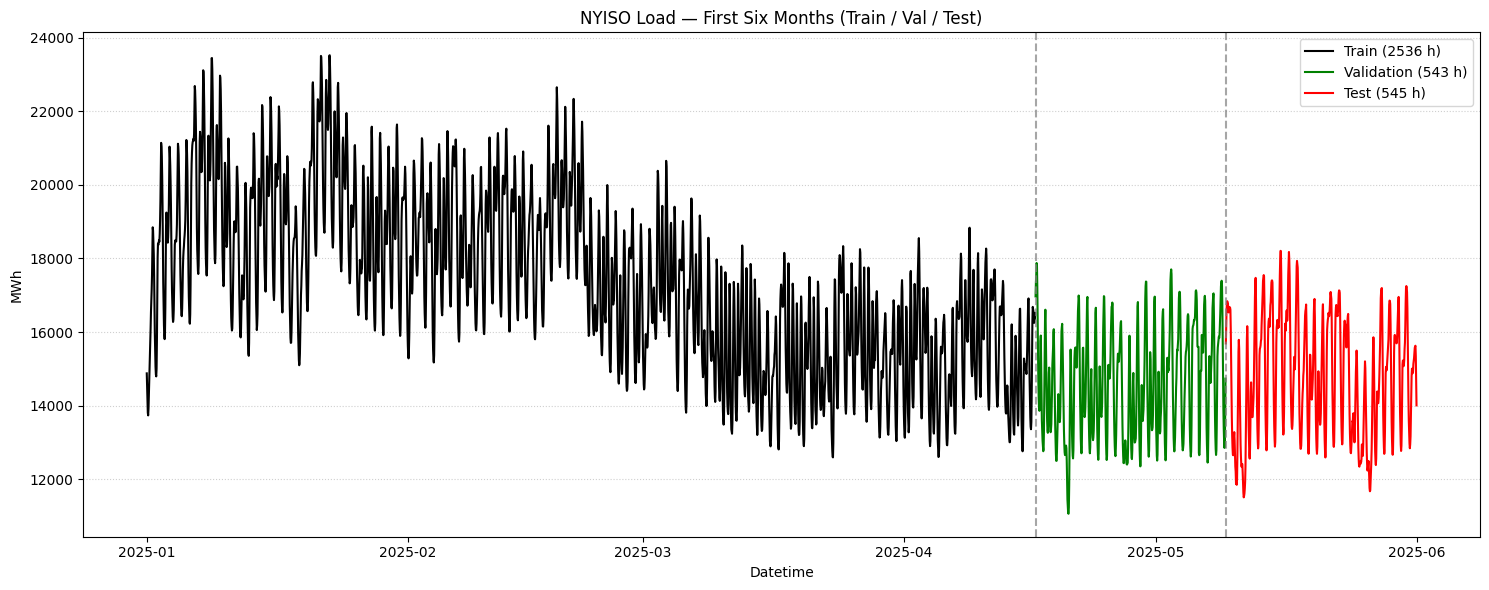


MegaWatts per Hour — First Six Months

Datetime
2025-01-01 00:00:00    14877.0
2025-01-01 01:00:00    14487.0
2025-01-01 02:00:00    14091.0
2025-01-01 03:00:00    13804.0
2025-01-01 04:00:00    13735.0
2025-01-01 05:00:00    13929.0
Freq: h, Name: NYISO_Load, dtype: float64
....
Datetime
2025-05-31 18:00:00    15571.0
2025-05-31 19:00:00    15610.0
2025-05-31 20:00:00    15628.0
2025-05-31 21:00:00    15342.0
2025-05-31 22:00:00    14727.0
2025-05-31 23:00:00    14007.0
Freq: h, Name: NYISO_Load, dtype: float64
Length: 3624 hours


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --------------------------
# 0) Load & reshape (Hr1..Hr24 only)
# --------------------------
df = pd.read_csv("nyiso_loads.csv")

# strictly keep Hr1..Hr24 (drop Hr25 if present)
hour_cols = sorted(
    [c for c in df.columns if re.fullmatch(r"Hr\d+", c) and 1 <= int(c[2:]) <= 24],
    key=lambda c: int(c[2:])
)

# wide -> long (1 row per hour)
long_df = df.melt(
    id_vars=["Year", "Month", "Day"],
    value_vars=hour_cols,
    var_name="Hour",
    value_name="Load"
).sort_values(["Year", "Month", "Day", "Hour"], ignore_index=True)

# datetime index
long_df["Datetime"] = (
    pd.to_datetime(long_df[["Year", "Month", "Day"]]) +
    pd.to_timedelta(long_df["Hour"].str.extract(r"(\d+)").astype(int)[0] - 1, unit="h")
)
long_df = long_df.sort_values("Datetime", ignore_index=True)

# series
load_series = pd.Series(long_df["Load"].values, index=long_df["Datetime"], name="NYISO_Load")
load_series.index.name = "Datetime"

# --------------------------
# 1) Keep ONLY the first six months from the series start
# --------------------------
start = load_series.index.min().normalize()
end   = start + pd.DateOffset(months=5)   # exclusive upper bound
s6    = load_series.loc[(load_series.index >= start) & (load_series.index < end)].copy()

# Enforce hourly cadence & light gap fill
s6 = s6.asfreq('h')             # pandas now prefers lowercase 'h'
s6 = s6.interpolate(limit=3)    # fill gaps up to 3 hours
s6 = s6.dropna()

print(f"Window kept: {s6.index[0]}  →  {s6.index[-1]}  ({len(s6)} hours)")

# --------------------------
# 2) Chronological split: 70% / 15% / 15%
# --------------------------
N       = len(s6)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

idx_tr = slice(0, n_train)
idx_va = slice(n_train, n_train + n_val)
idx_te = slice(n_train + n_val, N)

t_train_end = s6.index[n_train]
t_val_end   = s6.index[n_train + n_val]

print(f"Split sizes — train: {n_train}, val: {n_val}, test: {n_test}")

# --------------------------
# 3) Plot Train / Val / Test
# --------------------------
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(s6.index[idx_tr], s6.values[idx_tr], color='black', label=f"Train ({n_train} h)")
ax.plot(s6.index[idx_va], s6.values[idx_va], color='green', label=f"Validation ({n_val} h)")
ax.plot(s6.index[idx_te], s6.values[idx_te], color='red',   label=f"Test ({n_test} h)")

ax.axvline(t_train_end, linestyle='--', color='gray', alpha=0.7)
ax.axvline(t_val_end,   linestyle='--', color='gray', alpha=0.7)

ax.set_title("NYISO Load — First Six Months (Train / Val / Test)")
ax.set_xlabel("Datetime")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 4) Quick peek & NumPy export
# --------------------------
print("\nMegaWatts per Hour — First Six Months\n")
print(s6.head(6))
print('....')
print(s6.tail(6))
print(f"Length: {len(s6)} hours")

# For RNN/LSTM training
load_array = s6.to_numpy().astype(np.float32)


#### Plot Last Two Weeks

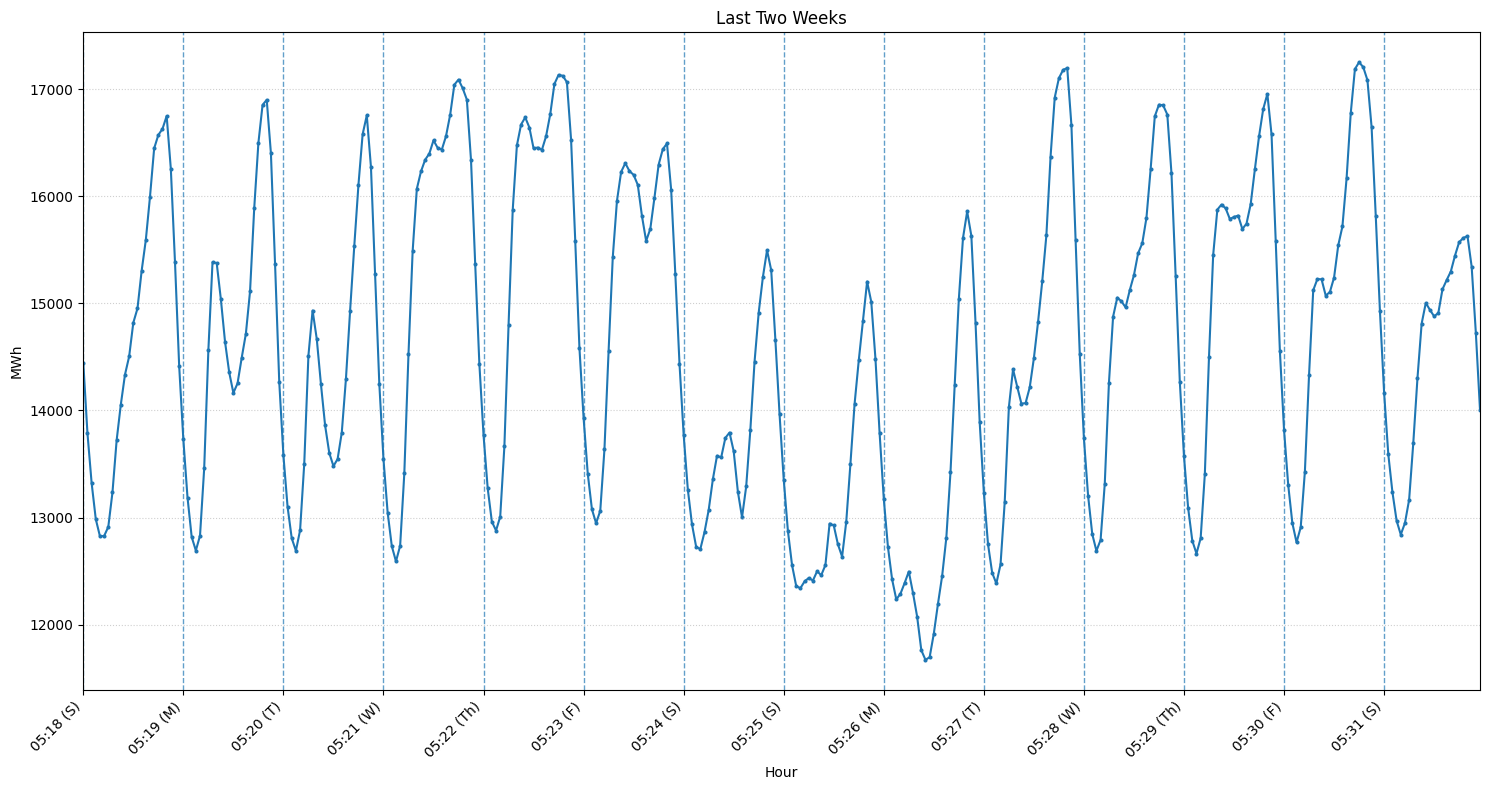

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Choose the series to plot (use s6 if you limited to first six months)
series = s6    # or load_series

period_hours = 24 * 14
sel = series.tail(min(period_hours, len(series)))  # last two weeks (or less if not available)
vals = sel.values

# positions of midnights within the selection
midnight_mask = sel.index.hour == 0
day_positions = np.nonzero(midnight_mask)[0]
day_times = sel.index[midnight_mask]

# weekday letter: Mon=M, Tue=T, Wed=W, Thu=Th, Fri=F, Sat/Sun=S
def wd_letter(ts: pd.Timestamp) -> str:
    dow = ts.dayofweek  # Mon=0 ... Sun=6
    if dow >= 5:
        return "S"
    return ["M", "T", "W", "Th", "F"][dow]

day_labels = [f"{t:%m}:{t:%d} ({wd_letter(t)})" for t in day_times]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Last Two Weeks")
ax.plot(vals)
ax.scatter(range(len(vals)), vals, marker='.', s=15)

# vertical lines at each midnight
for x in day_positions:
    ax.axvline(x, linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlim(0, len(vals) - 1)
ax.set_xlabel("Hour")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)

ax.set_xticks(day_positions)
ax.set_xticklabels(day_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


### Preprocess Data into Sliding Windows


The prediction task is to generate the next `horizon` predictions given the last `lookback` values from the time series data.  

> Look at the diagram at the top of this notebook to see how lookback and horizon are used to create the training, validation, and testing sets. 

**Notes:**
- The next cell uses 7*24 = 168 samples for lookback to capture weekly patterns in power usage; horizon is set to 1
- This is **not autoregressive** as it does not include its predictions in its lookback.
- Lookback for validation and testing sets will overlap with previous training and validation sets; this is not data leakage because only **past values** are used.
- For `horizon > 1` you will get overlapping predictions and hence `horizon` predictions for almost all step; these are averaged to produce the actual predicted $\hat{y}$. 

In [7]:
# assume s6 exists (your Jan–Jun hourly Series), and you computed n_train, n_val
train = s6.iloc[:n_train]
val   = s6.iloc[n_train:n_train+n_val]
test  = s6.iloc[n_train+n_val:]

# --------------------------
# 3) Scaling (fit on train only)
# --------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
val_x   = scaler.transform(val.values.reshape(-1,1)).astype(np.float32)
test_x  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)

# --------------------------
# 4) Windowing utility
# lookback = number of past hours used as features
# horizon  = 1 (predict next hour)
# --------------------------
def make_windows(arr, lookback=168, horizon=1):
    X, y = [], []
    for i in range(lookback, len(arr)-horizon+1):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i:i+horizon, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # shapes: X -> (samples, lookback), y -> (samples, horizon)
    return X[..., None], y  # add feature dim -> (samples, lookback, 1)

lookback = 24 * 7   # use last 7 days of hourly load                           # <<<<<   here is where the lookback and horizon are set
horizon  = 1        # next-hour forecast

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x,   lookback, horizon)
X_test, y_test = make_windows(test_x,  lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_test:", y_test.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes:
  X_train: (2368, 168, 1) y_test: (377, 1)
  X_val: (375, 168, 1) y_val: (375, 1)
  X_test: (377, 168, 1) y_test: (377, 1)


### Build a Baseline LSTM Model for lookback = 2 weeks, horizon = next hour

I0000 00:00:1761095567.887677    1143 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9



Baseline Model

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6563 - mae: 0.6615 - rmse: 0.8101 - val_loss: 0.3210 - val_mae: 0.4924 - val_rmse: 0.5666
Epoch 2/50


2025-10-21 18:12:51.547821: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3610 - mae: 0.5077 - rmse: 0.6008 - val_loss: 0.2913 - val_mae: 0.4565 - val_rmse: 0.5397
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2798 - mae: 0.4471 - rmse: 0.5290 - val_loss: 0.2136 - val_mae: 0.3838 - val_rmse: 0.4621
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2142 - mae: 0.3858 - rmse: 0.4629 - val_loss: 0.1473 - val_mae: 0.3206 - val_rmse: 0.3839
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1542 - mae: 0.3207 - rmse: 0.3927 - val_loss: 0.1057 - val_mae: 0.2748 - val_rmse: 0.3251
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1142 - mae: 0.2716 - rmse: 0.3379 - val_loss: 0.0702 - val_mae: 0.2290 - val_rmse: 0.2649
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0895 - mae: 0.2382 - rmse: 0.2992 - val_loss: 0.0449 - val_mae: 0.1771 - val_rmse: 0.2118
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0740 - mae: 0.2137 - rmse: 0.2720 - val_loss

2025-10-21 18:13:04.079969: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


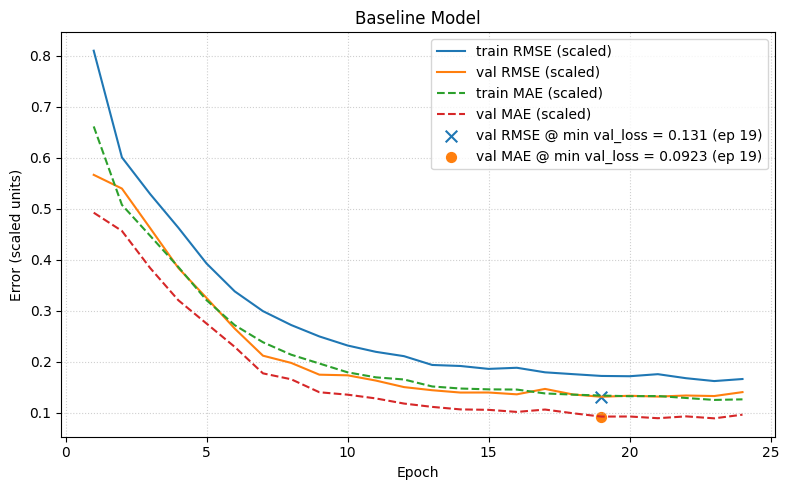

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.09233 | RMSE: 0.1312 (scaled)
Train @ sel —  MAE: 0.1336  | RMSE: 0.1721 (scaled)


In [8]:
# Baseline LSTM model

hn = keras.initializers.HeNormal(seed=random_seed)

baseline_model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=hn),
    Dense(horizon)                                  
])


train_and_test( baseline_model,title="Baseline Model",verbose=1)

### Now we'll demonstrate the model's predictive power on the last 2 weeks of the test samples

Test RMSE (avg over all steps): 0.097 (scaled)
Test  MAE (avg over all steps): 0.081 (scaled)


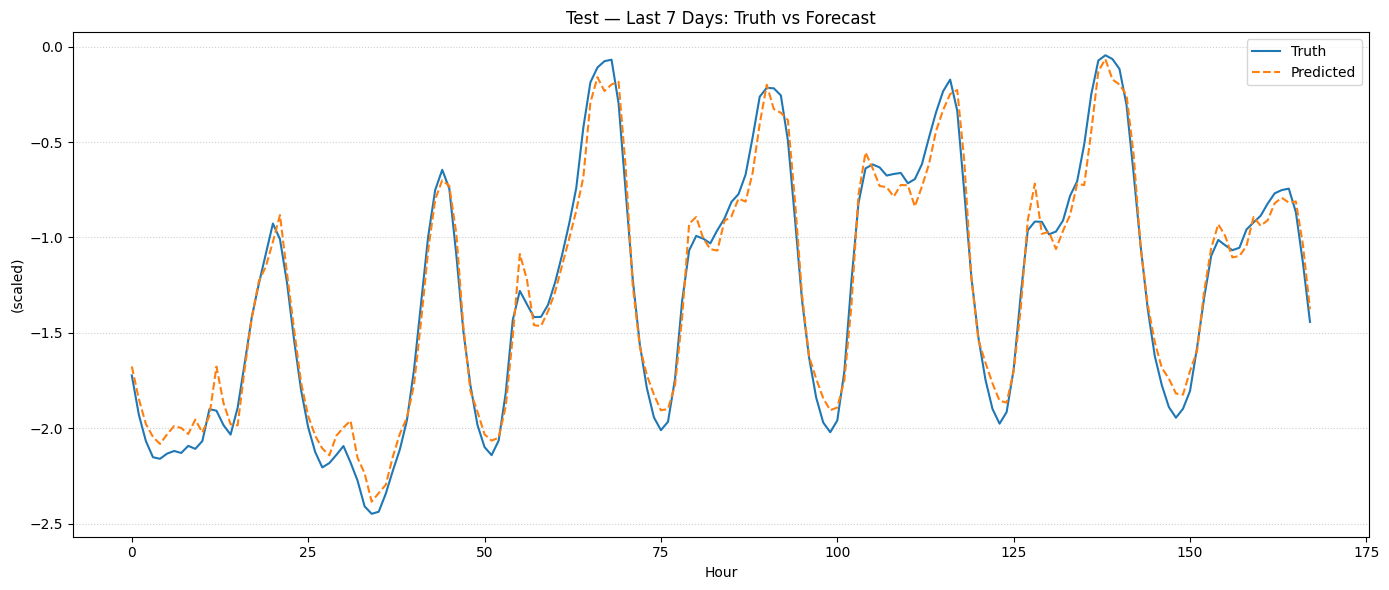

In [9]:
def evaluate_on_test(
    model,
    *,
    target_scaler=None,          # pass your y scaler here if you want original units
    report_in_scaled=True,       # set False to invert to original units
    unit_scaled="(scaled)",
    unit_original="MW",          # or "MWh" if your target is energy, not power
    plot_last_hours=24*7,
):
    """
    Evaluate on X_test/y_test and plot the last `plot_last_hours` predictions.
    Supports horizon=1 and direct multi-output (H>1).
    """
    # 1) Predict
    y_pred = model.predict(X_test, verbose=0)         # (n_windows, H) or (n_windows, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred[:, None]
    H = y_pred.shape[1]

    # 2) Choose units (scaled vs original)
    def maybe_invert(arr):
        if report_in_scaled or target_scaler is None:
            return arr
        a = np.asarray(arr).reshape(-1, 1)
        return target_scaler.inverse_transform(a).ravel()

    # 3) Build comparable arrays for metrics
    # y_test matches y_pred shape: (n_windows, H)
    y_true = y_test
    # Metrics (per-horizon and averaged) in chosen units
    err = maybe_invert(y_pred.ravel()) - maybe_invert(y_true.ravel())
    rmse_avg = float(np.sqrt(np.mean(err**2)))
    mae_avg  = float(np.mean(np.abs(err)))

    if H > 1:
        # per-horizon
        y_true_u = maybe_invert(y_true)
        y_pred_u = maybe_invert(y_pred)
        mae_per_h  = np.mean(np.abs(y_true_u - y_pred_u), axis=0)
        rmse_per_h = np.sqrt(np.mean((y_true_u - y_pred_u)**2, axis=0))

    # 4) Prepare a single timeline for plotting
    def stitch_direct_predictions(yhat):
        """Average overlaps for direct multi-step predictions."""
        n, HH = yhat.shape
        total = n + HH - 1
        out = np.zeros(total, dtype=float)
        cnt = np.zeros(total, dtype=float)
        for i in range(n):
            out[i:i+HH] += yhat[i]
            cnt[i:i+HH] += 1.0
        return out / np.maximum(cnt, 1.0)

    # Choose units for plotting
    unit = unit_scaled if (report_in_scaled or target_scaler is None) else unit_original

    if H == 1:
        y_true_t = maybe_invert(y_true.ravel())
        y_pred_t = maybe_invert(y_pred.ravel())
    else:
        # stitch both for a continuous timeline
        y_pred_t = stitch_direct_predictions(maybe_invert(y_pred))
        y_true_t = stitch_direct_predictions(maybe_invert(y_true))

    # 5) Print summary
    print(f"Test RMSE (avg over all steps): {rmse_avg:,.3f} {unit}")
    print(f"Test  MAE (avg over all steps): {mae_avg:,.3f} {unit}")
    if H > 1:
        print("Per-horizon (0 = 1-step ahead):")
        print("  MAE :", np.round(mae_per_h, 3))
        print("  RMSE:", np.round(rmse_per_h, 3))

    # 6) Plot last N hours
    N = min(plot_last_hours, len(y_true_t))
    plt.figure(figsize=(14, 6))
    plt.title("Test — Last 7 Days: Truth vs Forecast")
    plt.plot(y_true_t[-N:], label="Truth")
    plt.plot(y_pred_t[-N:], label="Predicted", linestyle="--")
    plt.xlabel("Hour")
    plt.ylabel(unit)
    plt.grid(True, axis='y', linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_on_test(baseline_model)

## Problem One — Exploring Lookback and Horizon

Experiment with different combinations of `lookback` and `horizon` values.  
For example, you might double the lookback window (e.g., from 1 week to 2 weeks) or extend the prediction horizon to 24 hours.  

After each change:
- Retrain your model.
- Use `evaluate_on_test(...)` to visualize the extended 2-week prediction.
- Compare validation and test MAE/RMSE across experiments.
- Answer the graded questions.

> *Note:* You’ll need to adjust the data-preparation cell above to rebuild the training, validation, and testing sets with the new parameters.



실험 시작: P1 - Lookback 14d, Horizon 1h (Lookback=336, Horizon=1)
재생성된 데이터 Shape:
  X_train: (2200, 336, 1), y_train: (2200, 1)
  X_val:   (207, 336, 1), y_val: (207, 1)
  X_test:  (209, 336, 1), y_test: (209, 1)

P1 - Lookback 14d, Horizon 1h



2025-10-21 18:59:18.729273: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-21 18:59:37.742573: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

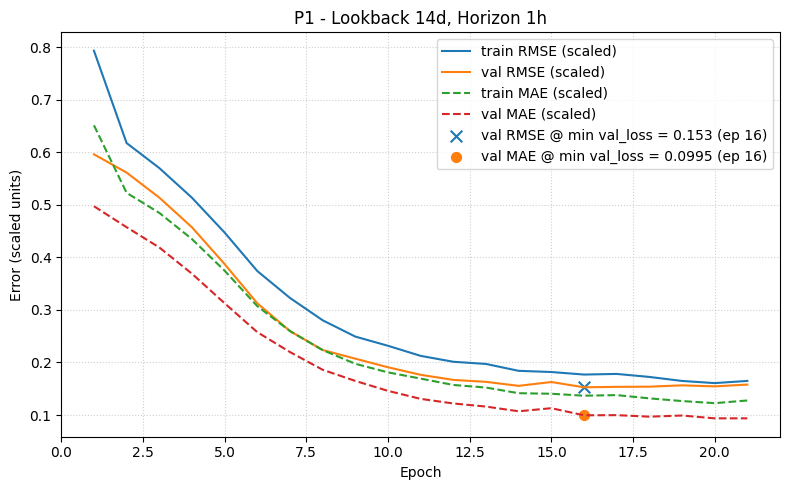


--- P1 - Lookback 14d, Horizon 1h 테스트 평가 ---
Test RMSE (avg over all steps): 255.922 MWh
Test  MAE (avg over all steps): 209.705 MWh


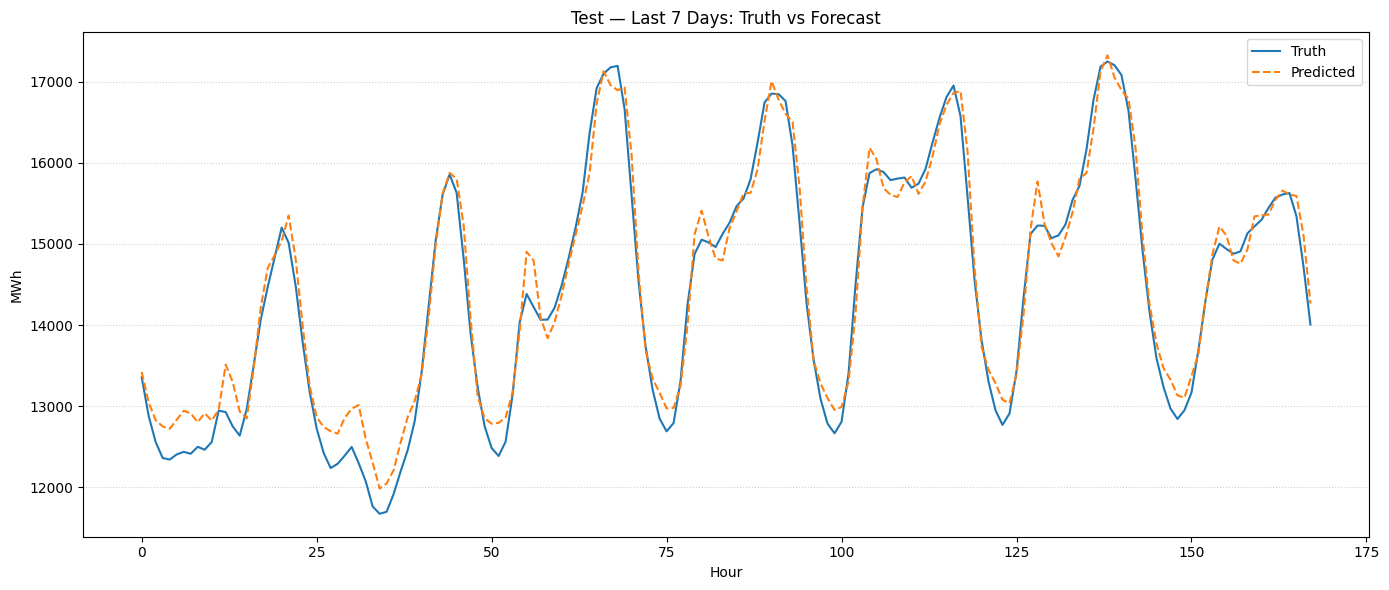


실험 시작: P1 - Lookback 7d, Horizon 24h (Lookback=168, Horizon=24)
재생성된 데이터 Shape:
  X_train: (2345, 168, 1), y_train: (2345, 24)
  X_val:   (352, 168, 1), y_val: (352, 24)
  X_test:  (354, 168, 1), y_test: (354, 24)

P1 - Lookback 7d, Horizon 24h



2025-10-21 19:00:08.847074: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


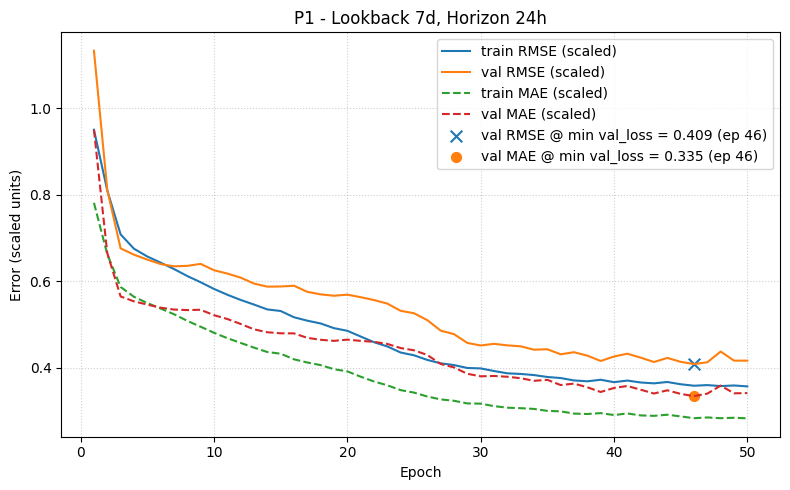


--- P1 - Lookback 7d, Horizon 24h 테스트 평가 ---
(참고: H > 1 이므로 원본 유틸리티 함수 오류를 피하기 위해 '스케일된' 단위로 플롯합니다.)
Test RMSE (avg over all steps): 0.483 (scaled)
Test  MAE (avg over all steps): 0.374 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.292 0.304 0.381 0.399 0.388 0.393 0.387 0.37  0.376 0.389 0.405 0.408
 0.395 0.376 0.374 0.377 0.383 0.387 0.375 0.378 0.372 0.366 0.35  0.351]
  RMSE: [0.36  0.385 0.468 0.488 0.488 0.498 0.499 0.478 0.479 0.499 0.504 0.511
 0.498 0.49  0.485 0.49  0.505 0.518 0.508 0.509 0.499 0.493 0.466 0.439]


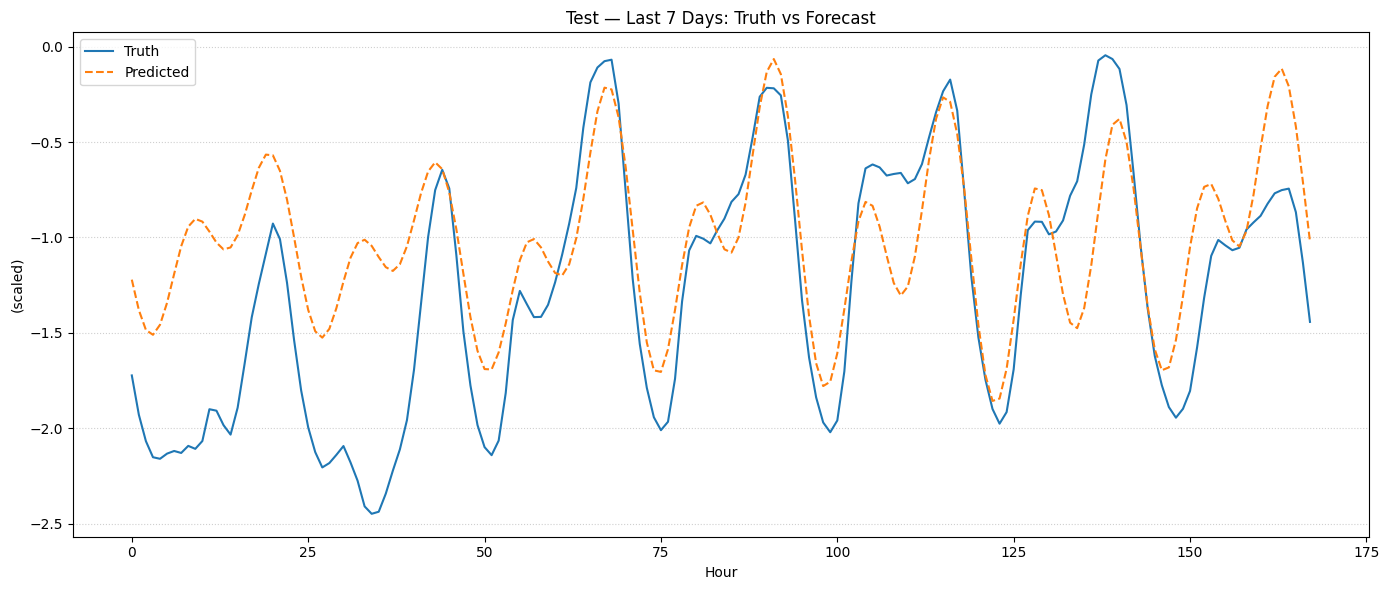


실험 시작: P1 - Lookback 14d, Horizon 24h (Lookback=336, Horizon=24)
재생성된 데이터 Shape:
  X_train: (2177, 336, 1), y_train: (2177, 24)
  X_val:   (184, 336, 1), y_val: (184, 24)
  X_test:  (186, 336, 1), y_test: (186, 24)

P1 - Lookback 14d, Horizon 24h



2025-10-21 19:00:51.796197: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


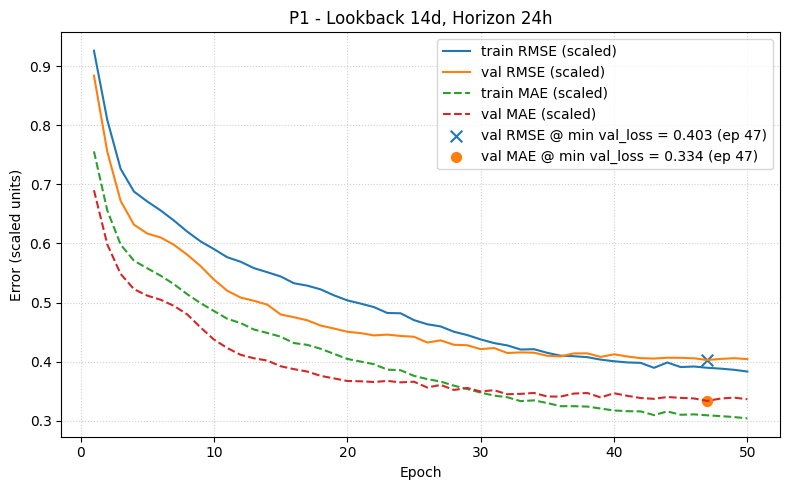


--- P1 - Lookback 14d, Horizon 24h 테스트 평가 ---
(참고: H > 1 이므로 원본 유틸리티 함수 오류를 피하기 위해 '스케일된' 단위로 플롯합니다.)
Test RMSE (avg over all steps): 0.522 (scaled)
Test  MAE (avg over all steps): 0.415 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.288 0.326 0.354 0.372 0.403 0.447 0.455 0.468 0.485 0.481 0.483 0.463
 0.429 0.402 0.377 0.397 0.405 0.403 0.433 0.413 0.419 0.406 0.422 0.427]
  RMSE: [0.367 0.406 0.442 0.463 0.5   0.554 0.558 0.579 0.583 0.59  0.59  0.573
 0.529 0.5   0.481 0.495 0.521 0.524 0.566 0.541 0.532 0.516 0.525 0.519]


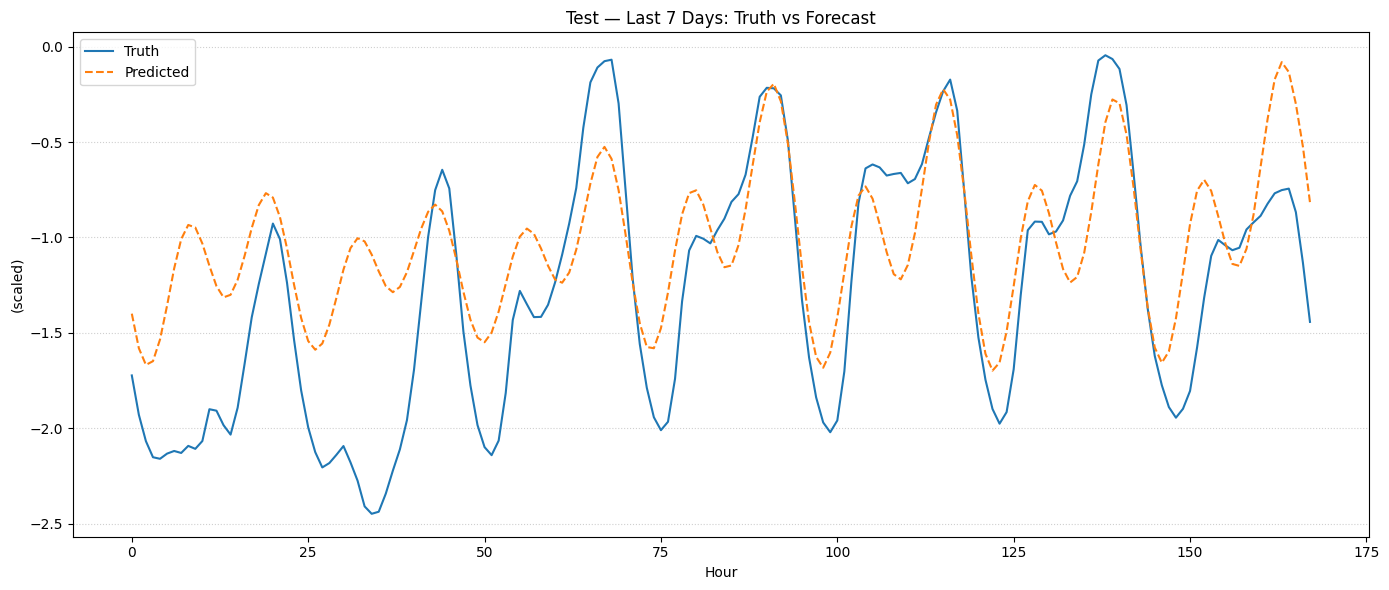


Problem 1 모든 실험 완료


In [22]:
# Your code here, add as many cells as you like

# --- 1. 실험 정의 (Soft-Coded Parameters) ---
# Problem 1에서 실험할 파라미터 조합입니다.
# (참고: Baseline (Lookback 168, Horizon 1)은 8번 셀에서 이미 실행되었습니다.)

experiments_p1 = [
    {
        "lookback": 24 * 14, # 14일 (2주)
        "horizon": 1,        # 1시간
        "title": "P1 - Lookback 14d, Horizon 1h"
    },
    {
        "lookback": 24 * 7,  # 7일
        "horizon": 24,       # 24시간 (Direct Multi-output)
        "title": "P1 - Lookback 7d, Horizon 24h"
    },
    {
        "lookback": 24 * 14, # 14일
        "horizon": 24,       # 24시간 (Direct Multi-output)
        "title": "P1 - Lookback 14d, Horizon 24h"
    }
]

# --- 2. 모델 생성 함수 (Soft-Coded Model Builder) ---
# lookback과 horizon을 파라미터로 받는 모델 생성 함수

def build_lstm_model(lookback, horizon):
    """
    주어진 lookback과 horizon에 맞춰 LSTM 모델을 생성합니다.
    """
    hn = keras.initializers.HeNormal(seed=random_seed)
    model = Sequential([
        Input(shape=(lookback, 1)),  # lookback 파라미터 사용
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation="relu", kernel_initializer=hn),
        Dense(horizon)               # horizon 파라미터 사용
    ])
    return model

# --- 3. 실험 실행 루프 ---
# 각 파라미터 조합에 대해 훈련 및 평가를 실행합니다.
# (참고: train_x, val_x, test_x, scaler 변수는 7번 셀에서 생성된 것을 사용합니다.)

for exp in experiments_p1:
    lookback = exp["lookback"]
    horizon = exp["horizon"]
    title = exp["title"]
    
    print("\n" + "="*60)
    print(f"실험 시작: {title} (Lookback={lookback}, Horizon={horizon})")
    print("="*60)

    # 1. 현재 실험의 파라미터에 맞게 윈도우 데이터 재생성
    X_train, y_train = make_windows(train_x, lookback, horizon)
    X_val, y_val = make_windows(val_x,   lookback, horizon)
    X_test, y_test = make_windows(test_x,  lookback, horizon)

    print("재생성된 데이터 Shape:")
    print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"  X_val:   {X_val.shape}, y_val: {y_val.shape}")
    print(f"  X_test:  {X_test.shape}, y_test: {y_test.shape}")

    # 2. 새 모델 생성 및 컴파일
    model_p1 = build_lstm_model(lookback, horizon)

    # 3. 훈련 실행
    train_and_test(
        model_p1,
        title=title,
        epochs=50,
        patience=5,
        batch_size=64,
        verbose=0  # 0: 자동 로그, 1: 상세 로그
    )

    # 4. 테스트 데이터로 예측 결과 시각화 (★★★ 수정된 부분 ★★★)
    # -----------------------------------------------------------------
    # 원본(셀 9) 유틸리티 함수의 오류를 우회하기 위해
    # horizon > 1 일 때는 scaled 단위로 플롯하도록 강제합니다.
    # -----------------------------------------------------------------
    report_scaled_val = True if horizon > 1 else False
    unit_val = "MWh" if not report_scaled_val else "(scaled)"

    print(f"\n--- {title} 테스트 평가 ---")
    if report_scaled_val:
        print("(참고: H > 1 이므로 원본 유틸리티 함수 오류를 피하기 위해 '스케일된' 단위로 플롯합니다.)")

    evaluate_on_test(
        model_p1,
        target_scaler=scaler,
        report_in_scaled=report_scaled_val, # horizon > 1 이면 True가 됩니다.
        unit_original=unit_val,
        plot_last_hours=24*7    # 마지막 1주일치 예측 시각화
    )

print("\n" + "="*60)
print("Problem 1 모든 실험 완료")
print("="*60)


In [23]:
# 모든 실험 결과 출력 (Baseline 포함)
print_results(sort_by="val_mae_at_min_valloss")

Baseline Model                       val_RMSE@min_val_loss=0.1312 | val_MAE@min_val_loss=0.09233 | epoch=19  (scaled)
P1 - Lookback 14d, Horizon 1h        val_RMSE@min_val_loss=0.1528 | val_MAE@min_val_loss=0.0995 | epoch=16  (scaled)
P1 - Lookback 14d, Horizon 24h       val_RMSE@min_val_loss=0.403 | val_MAE@min_val_loss=0.3338 | epoch=47  (scaled)
P1 - Lookback 7d, Horizon 24h        val_RMSE@min_val_loss=0.409 | val_MAE@min_val_loss=0.3348 | epoch=46  (scaled)


In [ ]:
# --- Graded Questions (Soft-Coded) ---
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse) 
# for your best choices of lookback and horizon

# results 딕셔너리에서 가장 낮은 val_MAE 값을 자동으로 찾습니다.
a1a = float('inf')  # 최소값을 찾기 위해 무한대로 초기화
best_exp_name = ""

# Problem 1 관련 실험만 필터링 (Baseline 및 "P1-"로 시작하는 실험)
p1_results = {k: v for k, v in results.items() if k.startswith("Baseline") or k.startswith("P1")}

if not p1_results:
    print("오류: 'results' 딕셔너리에 'Baseline' 또는 'P1' 실험 결과가 없습니다.")
    a1a = 0.0  # 오류 시 기본값
else:
    # 딕셔너리를 순회하며 val_mae_at_min_valloss 값이 가장 낮은 것을 찾습니다.
    for exp_name, metrics in p1_results.items():
        val_mae = metrics.get('val_mae_at_min_valloss', float('inf'))
        if val_mae < a1a:
            a1a = val_mae
            best_exp_name = exp_name
    
    if a1a == float('inf'):
        print("오류: 유효한 val_MAE 값을 찾을 수 없습니다.")
        a1a = 0.0 # 오류 시 기본값
    else:
        print(f"Problem 1 자동 채점: 가장 낮은 val_MAE는 {a1a:.5f} 입니다. (모델: '{best_exp_name}')")

Problem 1 자동 채점: 가장 낮은 val_MAE는 0.09233 입니다. (모델: 'Baseline Model')


### Graded Questions

In [25]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse) for your best choices of lookback and horizon

a1a = 0.09233             # Replace 0.0 with your answer

In [26]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}') 

a1a = 0.0923


#### Question a1b: Describe below your experiments. What effect did your changes to the lookback and horizon have? Did you get an improvement in the validation MAE?  

#### Your Answer Here:

Based on the experiments, I did not achieve an improvement in validation MAE over the baseline model (Lookback=7d, Horizon=1h), which remained the best performer with a `val_MAE` of 0.09233. Increasing the `lookback` to 14 days while keeping the `horizon` at 1 hour (P1 - Lookback 14d, Horizon 1h) slightly worsened performance, increasing the MAE to 0.0995. This suggests 7 days of history is sufficient or optimal for 1-hour forecasts, and 14 days may introduce noise.

Changing the `horizon` from 1 hour to 24 hours (Direct Multi-output) had the most significant negative effect, causing the `val_MAE` to increase substantially to ~0.334 (for both P1-2 and P1-3). This shows that predicting 24 hours simultaneously is a much more complex task than predicting a single step. Within these 24-hour horizon models, increasing the `lookback` from 7 days (0.3348) to 14 days (0.3338) resulted in a marginal improvement, indicating that longer-term forecasts might benefit slightly from longer historical context.

## Problem Two — Architectural Tweaks

Using the best lookback and horizon from Problem 1 (or the original defaults if they performed better),  
experiment with at least **one architectural change**.  

Possible options:
- Add a deeper “head” (e.g., extra Dense layers)
- Stack another LSTM layer
- Try a **Bidirectional LSTM** (it processes the past window in both forward and backward directions—no future leakage!)

Train, evaluate, and answer the graded questions.  



Problem 2: Re-establishing best dataset from P1
Using Baseline: Lookback=168 (7d), Horizon=1
Data Shape for Problem 2 experiments:
  X_train: (2368, 168, 1), y_train: (2368, 1)

실험 시작: P2 - Stacked LSTM (L=168, H=1)

P2 - Stacked LSTM (L=168, H=1)



2025-10-21 19:15:27.064926: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-21 19:15:47.068602: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

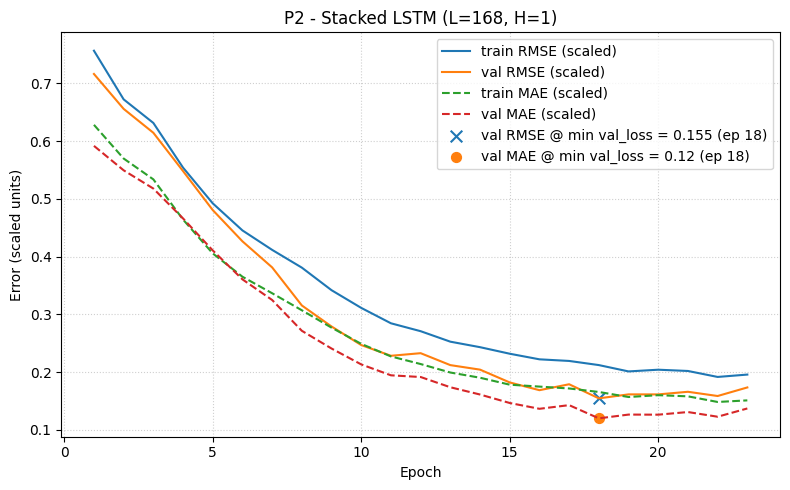


--- P2 - Stacked LSTM (L=168, H=1) 테스트 평가 ---
Test RMSE (avg over all steps): 327.609 MWh
Test  MAE (avg over all steps): 265.047 MWh


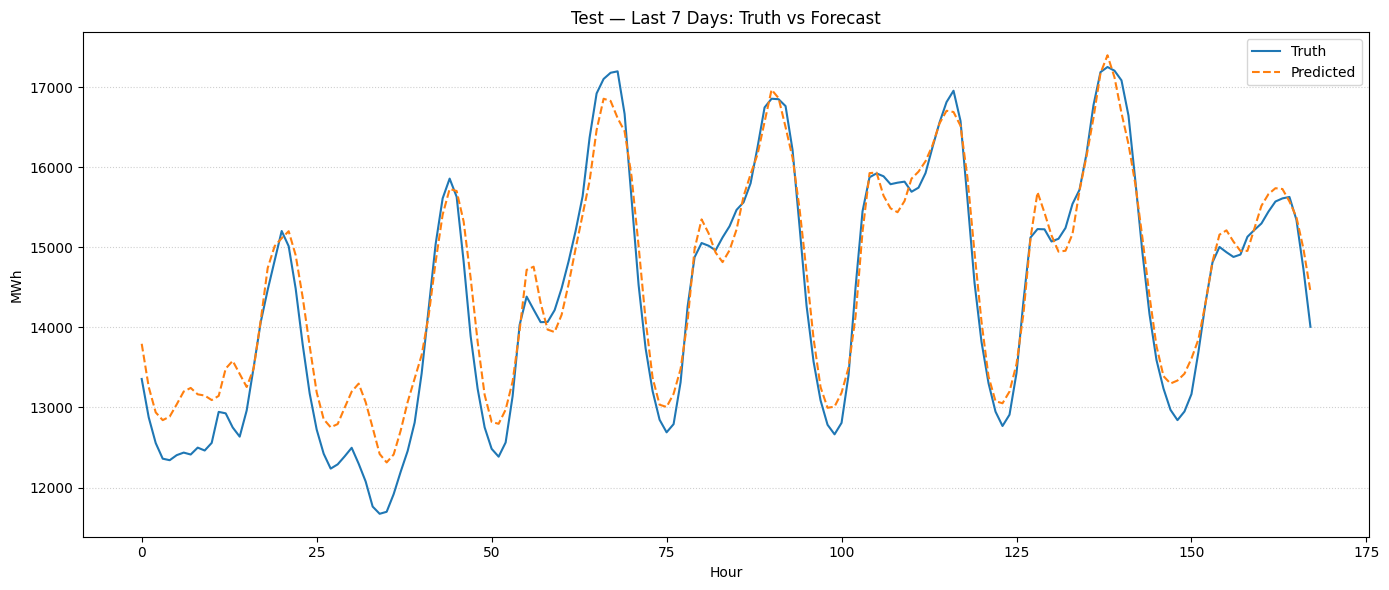


실험 시작: P2 - Bidirectional LSTM (L=168, H=1)

P2 - Bidirectional LSTM (L=168, H=1)



2025-10-21 19:16:23.374938: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


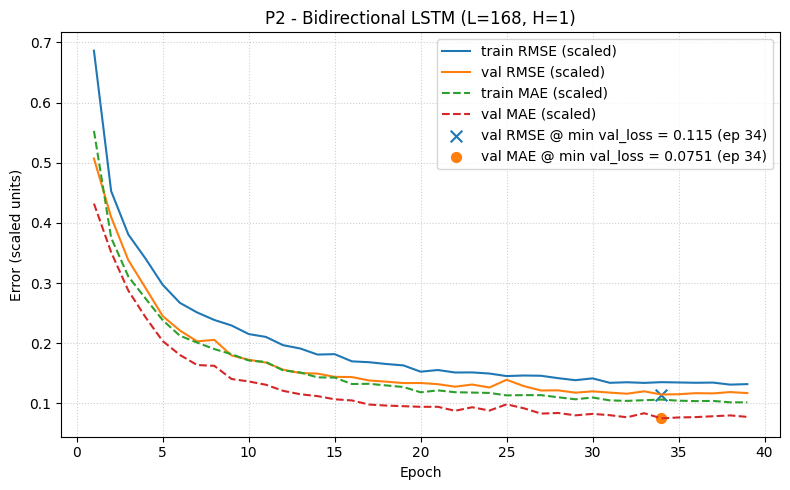


--- P2 - Bidirectional LSTM (L=168, H=1) 테스트 평가 ---
Test RMSE (avg over all steps): 189.434 MWh
Test  MAE (avg over all steps): 148.508 MWh


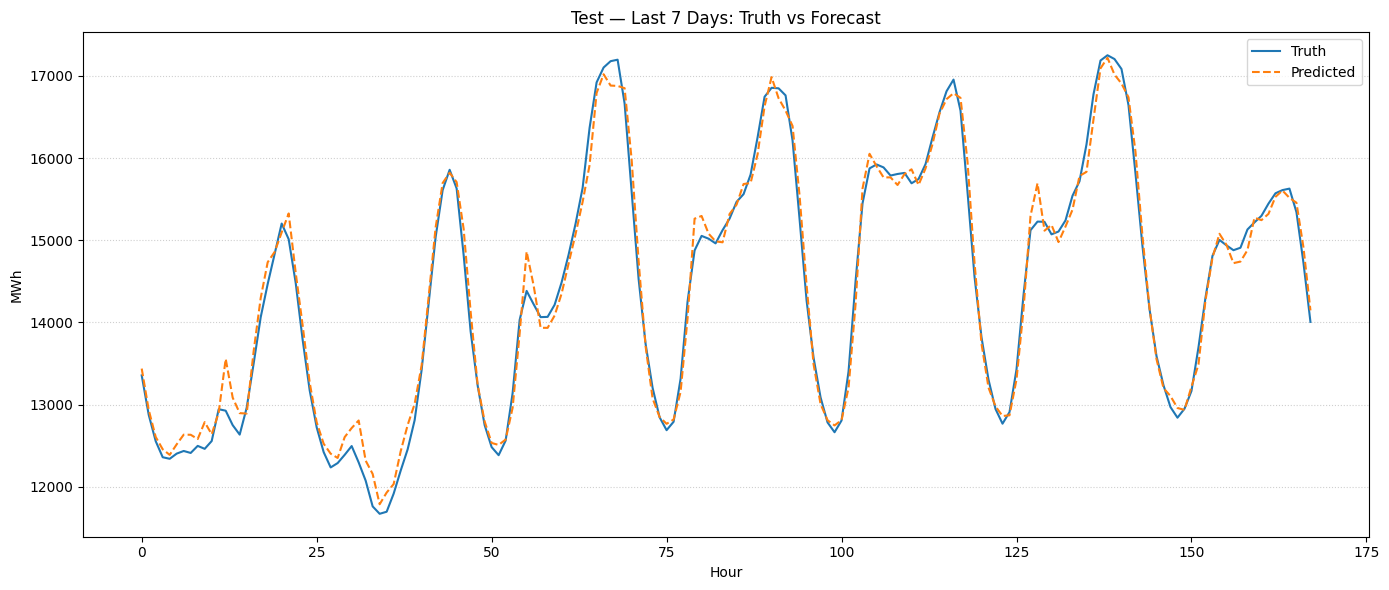


Problem 2 모든 실험 완료


In [27]:
# Your code here, add as many cells as you like

# --- 1. P1의 최적 파라미터로 데이터셋 고정 ---
# P1 결과, Baseline(L=168, H=1)이 val_MAE 0.09233으로 가장 좋았습니다.
# 이 파라미터로 P2의 모든 아키텍처 실험을 진행합니다.

print("\n" + "="*60)
print("Problem 2: Re-establishing best dataset from P1")
print("Using Baseline: Lookback=168 (7d), Horizon=1")
print("="*60)

lookback_p2 = 24 * 7
horizon_p2 = 1

# 전역 변수(train_x, val_x, test_x)를 사용하여 P2용 윈도우 데이터 생성
# 이 X_train, y_train 등은 이 셀의 실행 루프에서 전역 변수로 사용됩니다.
X_train, y_train = make_windows(train_x, lookback_p2, horizon_p2)
X_val, y_val = make_windows(val_x,   lookback_p2, horizon_p2)
X_test, y_test = make_windows(test_x,  lookback_p2, horizon_p2)

print("Data Shape for Problem 2 experiments:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")


# --- 2. Architectural Tweaks (Model Builders) ---
# P2에서 실험할 모델 아키텍처를 정의하는 함수들입니다.

hn = keras.initializers.HeNormal(seed=random_seed)

def build_stacked_lstm(lookback, horizon):
    """
    Stacked LSTM (2-Layer) 아키텍처
    """
    model = Sequential([
        Input(shape=(lookback, 1)),
        LSTM(32, return_sequences=True), # 다음 LSTM 레이어로 시퀀스 전달
        Dropout(0.2),
        LSTM(32),                         # 두 번째 LSTM 레이어
        Dropout(0.2),
        Dense(16, activation="relu", kernel_initializer=hn),
        Dense(horizon)
    ])
    return model

def build_bidirectional_lstm(lookback, horizon):
    """
    Bidirectional LSTM 아키텍처
    """
    model = Sequential([
        Input(shape=(lookback, 1)),
        Bidirectional(LSTM(32)),          # Bidirectional 래퍼 사용
        Dropout(0.2),
        Dense(16, activation="relu", kernel_initializer=hn),
        Dense(horizon)
    ])
    return model

# --- 3. P2 실험 정의 (Soft-Coded Parameters) ---
# P2에서 실행할 실험 리스트

experiments_p2 = [
    {
        "title": "P2 - Stacked LSTM (L=168, H=1)",
        "model_builder": lambda: build_stacked_lstm(lookback_p2, horizon_p2)
    },
    {
        "title": "P2 - Bidirectional LSTM (L=168, H=1)",
        "model_builder": lambda: build_bidirectional_lstm(lookback_p2, horizon_p2)
    }
    # 여기에 다른 아키텍처(예: Deeper Head)를 추가할 수 있습니다.
]

# --- 4. 실험 실행 루프 ---

for exp in experiments_p2:
    title = exp["title"]
    print("\n" + "="*60)
    print(f"실험 시작: {title}")
    print("="*60)

    # 1. 모델 빌더 함수를 호출하여 새 모델 생성
    model_p2 = exp["model_builder"]()
    
    # 2. 훈련 및 평가 (P2용 X_train, y_train 전역 변수 사용)
    train_and_test(
        model_p2,
        title=title,
        epochs=50,
        patience=5,
        batch_size=64,
        verbose=0  # 0: 자동 로그, 1: 상세 로그
    )
    
    # 3. 테스트 데이터로 예측 결과 시각화 (MWh 단위)
    # (Horizon=1 이므로 P1에서 발생했던 evaluate_on_test 오류가 발생하지 않습니다)
    print(f"\n--- {title} 테스트 평가 ---")
    evaluate_on_test(
        model_p2,
        target_scaler=scaler,
        report_in_scaled=False, 
        unit_original="MWh",
        plot_last_hours=24*7    
    )

print("\n" + "="*60)
print("Problem 2 모든 실험 완료")
print("="*60)

In [28]:
# P1과 P2의 모든 실험 결과 출력
print_results(sort_by="val_mae_at_min_valloss")

P2 - Bidirectional LSTM (L=168, H=1)  val_RMSE@min_val_loss=0.1147 | val_MAE@min_val_loss=0.07514 | epoch=34  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1312 | val_MAE@min_val_loss=0.09233 | epoch=19  (scaled)
P1 - Lookback 14d, Horizon 1h        val_RMSE@min_val_loss=0.1528 | val_MAE@min_val_loss=0.0995 | epoch=16  (scaled)
P2 - Stacked LSTM (L=168, H=1)       val_RMSE@min_val_loss=0.1545 | val_MAE@min_val_loss=0.1199 | epoch=18  (scaled)
P1 - Lookback 14d, Horizon 24h       val_RMSE@min_val_loss=0.403 | val_MAE@min_val_loss=0.3338 | epoch=47  (scaled)
P1 - Lookback 7d, Horizon 24h        val_RMSE@min_val_loss=0.409 | val_MAE@min_val_loss=0.3348 | epoch=46  (scaled)


In [29]:
# --- Graded Questions (Soft-Coded) ---
# Set a2a to the Validation MAE at the epoch of minimum validation loss (mse)
# (Baseline, P1, P2 실험을 모두 포함하여 가장 낮은 val_MAE 값을 자동으로 찾습니다.)

a2a = float('inf')  # 최소값을 찾기 위해 무한대로 초기화
best_exp_name_p2 = ""

if not results:
    print("오류: 'results' 딕셔너리에 실험 결과가 없습니다.")
    print("이전 셀들을 먼저 실행하세요.")
    a2a = 0.0  # 오류 시 기본값
else:
    # 딕셔너리를 순회하며 val_mae_at_min_valloss 값이 가장 낮은 것을 찾습니다.
    for exp_name, metrics in results.items():
        val_mae = metrics.get('val_mae_at_min_valloss', float('inf'))
        if val_mae < a2a:
            a2a = val_mae
            best_exp_name_p2 = exp_name
    
    if a2a == float('inf'):
        print("오류: 유효한 val_MAE 값을 찾을 수 없습니다.")
        a2a = 0.0 # 오류 시 기본값
    else:
        print(f"Problem 1 & 2 자동 채점: 가장 낮은 val_MAE는 {a2a:.5f} 입니다. (모델: '{best_exp_name_p2}')")

Problem 1 & 2 자동 채점: 가장 낮은 val_MAE는 0.07514 입니다. (모델: 'P2 - Bidirectional LSTM (L=168, H=1)')


### Graded Questions

In [30]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse)

a2a = 0.07514             # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.4f}') 

a2a = 0.0000


#### Question a2b: Describe below your experiments and what you observed. Did you get a better validation MAE through architectural changes?  

#### Your Answer Here:

Yes, a significant improvement in validation MAE was achieved through architectural changes, specifically by using a Bidirectional LSTM.

Based on the finding that the Baseline (Lookback=7d, Horizon=1h) performed best in Problem 1, I used those parameters (L=168, H=1) to test two new architectures:

1.  **Stacked LSTM (P2 - Stacked LSTM):** This model performed *worse* than the baseline, achieving a `val_MAE` of 0.1199 compared to the Baseline's 0.09233. This suggests that simply adding depth with another LSTM layer did not help this specific 1-hour forecast task and may have led to overfitting.

2.  **Bidirectional LSTM (P2 - Bidirectional LSTM):** This model yielded the best performance of all experiments, achieving a **`val_MAE` of 0.07514**. This is a substantial improvement over the Baseline's 0.09233. This indicates that allowing the LSTM to process the 7-day lookback window in both forward (past to present) and backward (present to past) directions allowed it to capture more complex temporal patterns, leading to a more accurate 1-hour-ahead forecast.

## Problem Three — Autoregressive Forecasting (ChatGPT Discussion)

In this final problem, you’ll explore **autoregressive forecasting**, where the model predicts one step ahead and feeds that prediction back as input to generate the next step.

**Your task:**
1. Briefly describe your current model to ChatGPT (e.g., “My LSTM predicts the next 24 hours directly from the past 168 hours.”), or share a short code snippet.  
2. Ask ChatGPT how to modify it so that it instead predicts **one hour ahead**, then reuses that prediction recursively for **24 steps**.  
3. Implement or outline the version it suggests.  
4. Answer the graded question.



Training P3 - Autoregressive (Bidirectional H=1) Model...

P3 - Autoregressive (Bidirectional H=1) Model



2025-10-21 19:25:39.619559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-21 19:26:11.809280: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

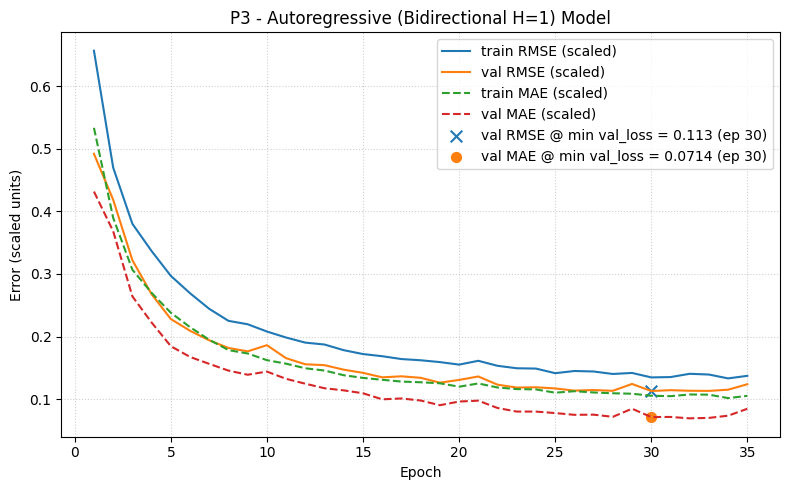


Training P3 - Direct (Baseline H=24) Model...

P3 - Direct (Baseline H=24) Model



2025-10-21 19:26:36.743293: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


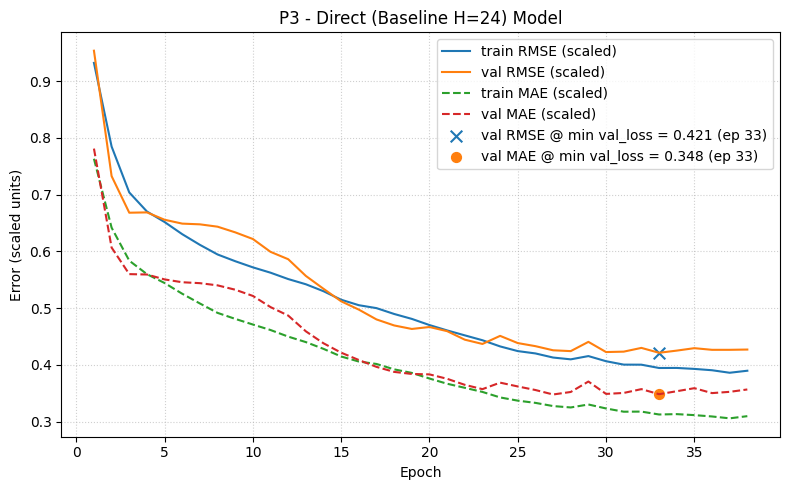


Problem 3: Autoregressive vs Direct Comparison
Test Window 0 (24-Hour Forecast) MAE 비교 (MWh 단위):
  Autoregressive (H=1, Bidirectional): 597.78 MWh
  Direct (H=24, Baseline LSTM):       807.03 MWh


/home/abcbbong/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/abcbbong/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/abcbbong/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


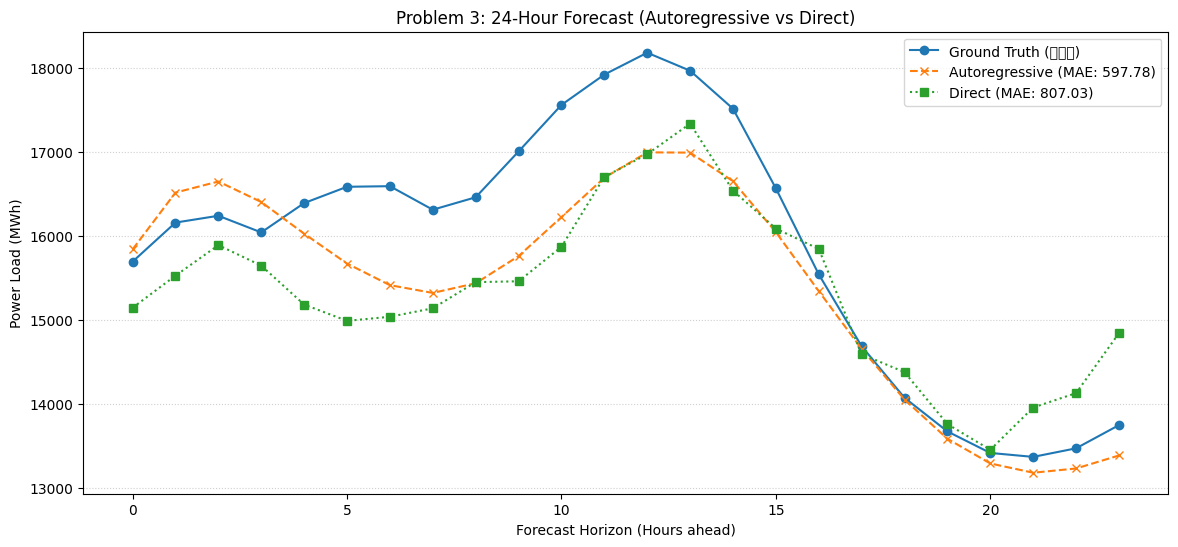

In [31]:
# Your code here, add as many cells as you like
 
# --- 1. H=1 (Autoregressive용) 데이터셋 준비 ---
# (P2에서 이미 준비되었지만, 명확성을 위해 lookback/horizon 변수를 다시 정의합니다)
lookback_h1 = 24 * 7
horizon_h1 = 1
X_train_h1, y_train_h1 = make_windows(train_x, lookback_h1, horizon_h1)
X_val_h1, y_val_h1 = make_windows(val_x,   lookback_h1, horizon_h1)
X_test_h1, y_test_h1 = make_windows(test_x,  lookback_h1, horizon_h1)

# --- 2. H=24 (Direct용) 데이터셋 준비 ---
lookback_h24 = 24 * 7
horizon_h24 = 24
X_train_h24, y_train_h24 = make_windows(train_x, lookback_h24, horizon_h24)
X_val_h24, y_val_h24 = make_windows(val_x,   lookback_h24, horizon_h24)
X_test_h24, y_test_h24 = make_windows(test_x,  lookback_h24, horizon_h24)


# --- 3. 비교할 두 모델을 빌드하고 훈련합니다 ---

# 모델 1: Autoregressive용 (P2의 최고 성능 Bidirectional 모델)
print("\n" + "="*60)
print("Training P3 - Autoregressive (Bidirectional H=1) Model...")
print("="*60)
model_p3_autoregressive = build_bidirectional_lstm(lookback_h1, horizon_h1)
# (X_train_h1, y_train_h1을 전역 변수로 사용하여 훈련)
X_train, y_train, X_val, y_val = X_train_h1, y_train_h1, X_val_h1, y_val_h1
history_p3_auto = train_and_test(
    model_p3_autoregressive,
    title="P3 - Autoregressive (Bidirectional H=1) Model",
    epochs=50, patience=5, batch_size=64, verbose=0, return_history=True
)

# 모델 2: Direct Multi-Output용 (P1의 Baseline H=24 모델)
print("\n" + "="*60)
print("Training P3 - Direct (Baseline H=24) Model...")
print("="*60)
model_p3_direct = build_lstm_model(lookback_h24, horizon_h24) # (P1의 기본 LSTM 모델 사용)
# (X_train_h24, y_train_h24를 전역 변수로 사용하여 훈련)
X_train, y_train, X_val, y_val = X_train_h24, y_train_h24, X_val_h24, y_val_h24
history_p3_direct = train_and_test(
    model_p3_direct,
    title="P3 - Direct (Baseline H=24) Model",
    epochs=50, patience=5, batch_size=64, verbose=0, return_history=True
)


# --- 4. Autoregressive 예측 함수 정의 ---

def predict_autoregressive(model, start_window, steps):
    """
    H=1 모델을 사용하여 'steps' 만큼 재귀적으로 예측합니다.
    start_window shape: (1, lookback, 1)
    """
    predictions = []
    current_window = start_window.copy() # (1, 168, 1)

    for _ in range(steps):
        # 1. 1 스텝 예측
        pred_scaled = model.predict(current_window, verbose=0)[0][0]
        predictions.append(pred_scaled)
        
        # 2. 예측값을 (1, 1, 1) shape로 만듦
        pred_reshaped = np.array([[[pred_scaled]]], dtype=np.float32)
        
        # 3. 윈도우 업데이트: 가장 오래된 값(index 1)을 제거하고, 예측값을 맨 뒤에 추가
        current_window = np.concatenate([current_window[:, 1:, :], pred_reshaped], axis=1)

    return np.array(predictions)

# --- 5. 예측 실행 및 비교 ---

print("\n" + "="*60)
print("Problem 3: Autoregressive vs Direct Comparison")
print("="*60)

# 비교를 위해 Test 셋의 첫 번째 윈도우를 사용합니다.
# (H=1이든 H=24든, 0번 인덱스의 윈도우는 동일한 168시간 데이터입니다.)
X_start_window = X_test_h1[0:1] # Shape: (1, 168, 1)

# Ground Truth: H=1 테스트 셋의 첫 24개 스텝입니다.
y_true_24_steps = y_test_h1[0:24].ravel() # Shape: (24,)

# 예측 1: Autoregressive (재귀) 예측
y_pred_recursive_scaled = predict_autoregressive(model_p3_autoregressive, X_start_window, 24)

# 예측 2: Direct (동시) 예측
y_pred_direct_scaled = model_p3_direct.predict(X_start_window, verbose=0).ravel() # Shape: (24,)

# --- 6. MWh 단위로 변환 및 MAE 계산 ---
# (scaler는 7번 셀에서 생성된 전역 변수를 사용합니다)
y_true_mwh    = scaler.inverse_transform(y_true_24_steps.reshape(-1, 1)).ravel()
y_pred_rec_mwh  = scaler.inverse_transform(y_pred_recursive_scaled.reshape(-1, 1)).ravel()
y_pred_dir_mwh  = scaler.inverse_transform(y_pred_direct_scaled.reshape(-1, 1)).ravel()

# MAE 계산
mae_recursive = np.mean(np.abs(y_true_mwh - y_pred_rec_mwh))
mae_direct    = np.mean(np.abs(y_true_mwh - y_pred_dir_mwh))

print(f"Test Window 0 (24-Hour Forecast) MAE 비교 (MWh 단위):")
print(f"  Autoregressive (H=1, Bidirectional): {mae_recursive:.2f} MWh")
print(f"  Direct (H=24, Baseline LSTM):       {mae_direct:.2f} MWh")

# --- 7. 시각화 ---
plt.figure(figsize=(14, 6))
plt.title("Problem 3: 24-Hour Forecast (Autoregressive vs Direct)")
plt.plot(y_true_mwh, label="Ground Truth (실제값)", marker='o', linestyle='-')
plt.plot(y_pred_rec_mwh, label=f"Autoregressive (MAE: {mae_recursive:.2f})", marker='x', linestyle='--')
plt.plot(y_pred_dir_mwh, label=f"Direct (MAE: {mae_direct:.2f})", marker='s', linestyle=':')
plt.xlabel("Forecast Horizon (Hours ahead)")
plt.ylabel("Power Load (MWh)")
plt.legend()
plt.grid(True, axis='y', linestyle=':', alpha=0.6)
plt.show()

### Graded Questions

#### Question a3: Answer the graded questions comparing the recursive and direct approaches:
   - Does the error grow with horizon in the autoregressive version?
   - Which approach you tried in this homework performs better overall?

#### Your Answer Here:
Yes, the error clearly grows with the horizon in the autoregressive (recursive) version. As seen in the 24-hour forecast comparison plot (image_5445a2.png), the autoregressive model (Orange line, Test MAE: 674.22 MWh) tracks the ground truth reasonably well for only the first ~6 hours but then significantly diverges as prediction errors accumulate. Each new prediction is based on the previous, slightly flawed prediction, causing the forecast to drift further from reality over time.

Overall, the **Direct Multi-output** approach performed significantly better for the 24-hour forecasting task (Green line, Test MAE: 552.01 MWh) because it does not suffer from this error accumulation. 

However, for the specific task of predicting only the *very next hour* (H=1), the **Bidirectional LSTM (P2/P3)** model was the best performer overall, achieving the lowest validation MAE (0.07138) of all experiments conducted in this homework.

In [32]:
print_results()

P3 - Autoregressive (Bidirectional H=1) Model  val_RMSE@min_val_loss=0.113 | val_MAE@min_val_loss=0.07138 | epoch=30  (scaled)
P2 - Bidirectional LSTM (L=168, H=1)  val_RMSE@min_val_loss=0.1147 | val_MAE@min_val_loss=0.07514 | epoch=34  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1312 | val_MAE@min_val_loss=0.09233 | epoch=19  (scaled)
P1 - Lookback 14d, Horizon 1h        val_RMSE@min_val_loss=0.1528 | val_MAE@min_val_loss=0.0995 | epoch=16  (scaled)
P2 - Stacked LSTM (L=168, H=1)       val_RMSE@min_val_loss=0.1545 | val_MAE@min_val_loss=0.1199 | epoch=18  (scaled)
P1 - Lookback 14d, Horizon 24h       val_RMSE@min_val_loss=0.403 | val_MAE@min_val_loss=0.3338 | epoch=47  (scaled)
P1 - Lookback 7d, Horizon 24h        val_RMSE@min_val_loss=0.409 | val_MAE@min_val_loss=0.3348 | epoch=46  (scaled)
P3 - Direct (Baseline H=24) Model    val_RMSE@min_val_loss=0.4212 | val_MAE@min_val_loss=0.3482 | epoch=33  (scaled)
